# Часть 1: анализ ридов Illumina

## 0. Разбораться с Bowtie2 / bwa mem

../bwa-0.7.17/bwa index MG1655-K12.first10K.fasta 

../bwa-0.7.17/bwa mem MG1655-K12.first10K.fasta 100x.1.fastq 100x.2.fastq > 100x.sam

../bwa-0.7.17/bwa index MG1655-K12.fasta

../bwa-0.7.17/bwa mem -t 4 MG1655-K12.fasta ecoli_mda_lane1_left.downsampled.fastq ecoli_mda_lane1_right.downsampled.fastq > ecoli_mda_lane1.downsampled.sam

../samtools-1.11/samtools view -S -b ecoli_mda_lane1.downsampled.sam > ecoli_mda_lane1.downsampled.bam

../samtools-1.11/samtools view -S -b 100x.sam > 100x.bam

### ../samtools-1.11/samtools flagstats 100x.bam

5000043 + 0 in total (QC-passed reads + QC-failed reads)

0 + 0 secondary

43 + 0 supplementary

0 + 0 duplicates

15659 + 0 mapped (0.31% : N/A)

5000000 + 0 paired in sequencing

2500000 + 0 read1

2500000 + 0 read2

10584 + 0 properly paired (0.21% : N/A)

11128 + 0 with itself and mate mapped

4488 + 0 singletons (0.09% : N/A)

0 + 0 with mate mapped to a different chr

0 + 0 with mate mapped to a different chr (mapQ>=5)

### ../samtools-1.11/samtools flagstats ecoli_mda_lane1.downsampled.bam

5869324 + 0 in total (QC-passed reads + QC-failed reads)

0 + 0 secondary

40558 + 0 supplementary

0 + 0 duplicates

5706866 + 0 mapped (97.23% : N/A)

5828766 + 0 paired in sequencing

2914383 + 0 read1

2914383 + 0 read2

5144614 + 0 properly paired (88.26% : N/A)

5647336 + 0 with itself and mate mapped

18972 + 0 singletons (0.33% : N/A)

0 + 0 with mate mapped to a different chr

0 + 0 with mate mapped to a different chr (mapQ>=5)

## 1. Покрытие генома.

In [63]:
from pyBedGraph import BedGraph
import matplotlib.pyplot as plt

### test

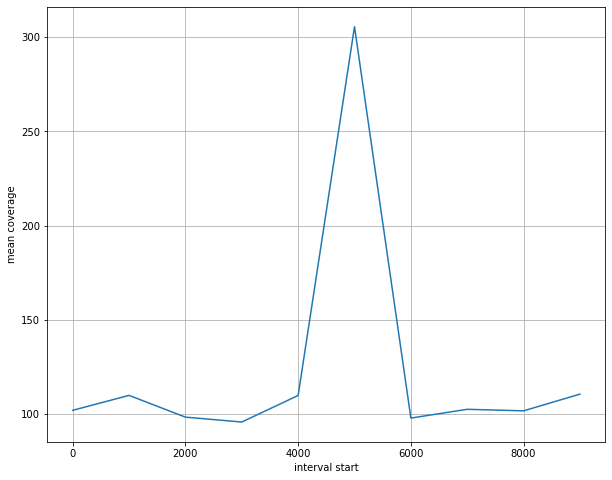

In [20]:
inclusive_bedGraph = BedGraph('100x.sizes', '100x.BEDGRAPH', ignore_missing_bp=False)

inclusive_bedGraph.load_chrom_data('gi|49175990|ref|NC_000913.2|')

start_list = list(range(0, 10000, 1000))
end_list   = list(range(1000, 11000, 1000))

result = inclusive_bedGraph.stats('mean', start_list=start_list, end_list=end_list, chrom_name='gi|49175990|ref|NC_000913.2|')

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
ax.plot(start_list, result)
ax.set_xlabel('interval start')
ax.set_ylabel('mean coverage')
ax.grid(True)
plt.show()

### E. coli

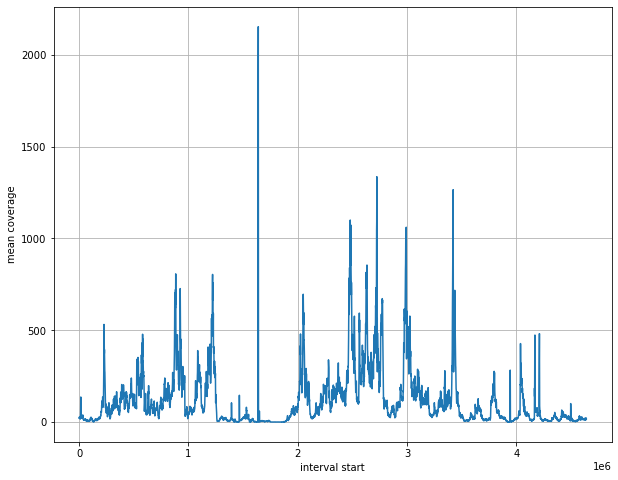

In [21]:
inclusive_bedGraph = BedGraph('ecoli_mda_lane1.downsampled.sizes', 'ecoli_mda_lane1.downsampled.BEDGRAPH', ignore_missing_bp=False)

inclusive_bedGraph.load_chrom_data('gi|49175990|ref|NC_000913.2|')

start_list = list(range(0, 4640000, 1000))
end_list   = list(range(1000, 4641000, 1000))

result = inclusive_bedGraph.stats('mean', start_list=start_list, end_list=end_list, chrom_name='gi|49175990|ref|NC_000913.2|')

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
ax.plot(start_list, result)
ax.set_xlabel('interval start')
ax.set_ylabel('mean coverage')
ax.grid(True)
plt.show()

## 2. Распределение расстояния вставки.

### test

cut -f 9 100x.sam > 100x_tlen.txt

count: 5000043
mean: 0.0
std: 9.918440787042677
tlen
 0      4988915
 216        206
-216        206
 213        195
-213        195
         ...   
-33           1
-32           1
-31           1
 248          1
-249          1
Length: 223, dtype: int64


<AxesSubplot:ylabel='Frequency'>

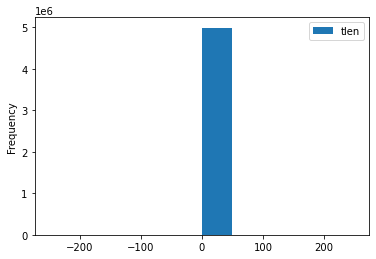

In [6]:
import pandas as pd

file1 = open('100x_tlen.txt', 'r')
lines = file1.read().splitlines()
file1.close()

lengths = map(lambda x: int(x), lines[2:])
df = pd.DataFrame(lengths, columns=['tlen'])

n = df.count()
m = df.mean()
s = df.std()
print('count:', n[0])
print('mean:', m[0])
print('std:', s[0])
print(df.value_counts())
df.plot.hist()

`>`95% ридов имеют расстояние вставки 0

### E. coli

cut -f 9 ecoli_mda_lane1.downsampled.sam > ecoli_tlen.txt

count: 5869324
mean: -3.947940853154469
std: 248359.5469418525
probability that insert size in (-333, 333): 0.9517970042205882


<AxesSubplot:ylabel='Frequency'>

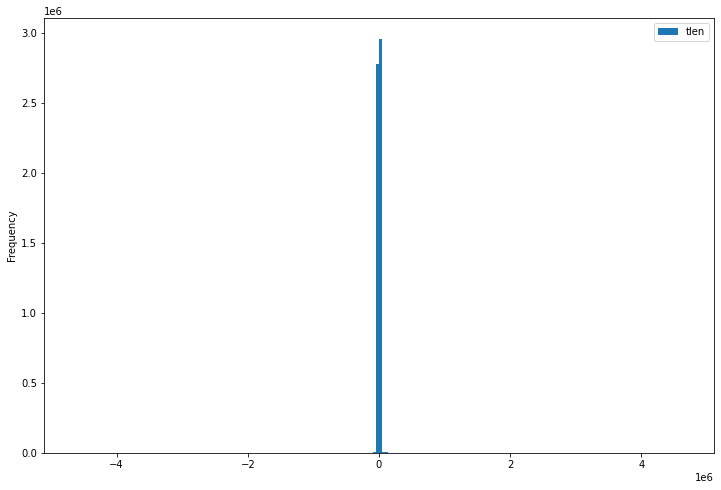

In [50]:
file1 = open('ecoli_tlen.txt', 'r')
lines = file1.read().splitlines()
file1.close()

lengths = map(lambda x: int(x), lines[2:])
df = pd.DataFrame(lengths, columns=['tlen'])

n = df.count()
m = df.mean()
s = df.std()
print('count:', n[0])
print('mean:', m[0])
print('std:', s[0])

p = df.query('tlen > -333 & tlen < 333').count()/n
print('probability that insert size in (-333, 333):', p[0])

df.plot.hist(bins=200, figsize=(12, 8))

так как распределение почти симметрично, то самый узкий интервал будет симметричен относительно среднего;

интервал (-333, 333) найден подбором.

## 3. Частоты различных замен

### test

**commands:**

../samtools-1.11/samtools mpileup -uf MG1655-K12.first10K.fasta 100x.sorted.bam  > 100x.bcf

bcftools stats 100x.bcf

../samtools-1.11/samtools stats 100x.sorted.bam

**results:**

| Reference\Read | A   | C   | G   | T   |
|:-------------- |:---:|:---:|:---:|:---:|
| A              | -   | 243 | 139 | 25  |
| C              | 79  | -   | 70  | 57  |
| G              | 70  | 66  | -   | 91  |
| T              | 27  | 102 | 254 | -   |

error rate:	1.399007e-02	# mismatches / bases mapped (cigar)

средний процент ошибок в ридах 1.4%

### E. coli

**commands:**

../samtools-1.11/samtools mpileup -uf MG1655-K12.fasta ecoli_mda_lane1.downsampled.sorted.bam > ecoli_mda_lane1.downsampled.bcf

bcftools stats ecoli_mda_lane1.downsampled.bcf

../samtools-1.11/samtools stats ecoli_mda_lane1.downsampled.sorted.bam > ecoli_stats.txt

grep 'error rate' ecoli_stats.txt

**results:**

| Reference\Read | A      | C      | G      | T      |
|:-------------- |:------:|:------:|:------:|:------:|
| A              | -      | 272881 | 197187 | 105399 |
| C              | 163240 | -      | 133370 | 111335 |
| G              | 110702 | 133567 | -      | 161185 |
| T              | 106114 | 198030 | 270321 | -      |

SN	error rate:	8.110126e-03	# mismatches / bases mapped (cigar)

средний процент ошибок в ридах 0.8%

# Часть 2: анализ ридов IonTorrent

## 1. Статистика ридов IonTorrent

In [110]:
import math
from pyBedGraph import BedGraph
import matplotlib.pyplot as plt
import pysam
import pandas as pd

def coverage_stats(sizes_path, bedgraph_path, chrom, length):
    inclusive_bedGraph = BedGraph(sizes_path, bedgraph_path, ignore_missing_bp=False)

    inclusive_bedGraph.load_chrom_data(chrom)

    r = 1000*math.ceil(length/1000)
    start_list = list(range(0, r, 1000))
    end_list   = list(range(1000, r+1000, 1000))

    result = inclusive_bedGraph.stats('mean', start_list=start_list, end_list=end_list, chrom_name=chrom)
    
    print('среднее покрытие (по всему референсному геному):', inclusive_bedGraph.stats('mean', start_list=[0], end_list=[length], chrom_name=chrom)[0])

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(8)
    ax.plot(start_list, result)
    ax.set_xlabel('interval start')
    ax.set_ylabel('mean coverage')
    ax.set_title('среднее покрытие (по 1000 нуклеотидов):')
    ax.grid(True)
    plt.show()
    
def nucl_quality_stats(path, chrom):
    samfile = pysam.AlignmentFile(path, "rb")

    inserts = Counter()
    substitutions = Counter()
    n = 0
    for pileupcolumn in samfile.pileup(chrom):
        for pileupread in pileupcolumn.pileups:
            if pileupread.is_del:
                continue
            
            if pileupread.indel:
                inserts.incr(pileupread.alignment.query_qualities[pileupread.query_position])
                continue
                
            if pileupread.alignment.get_aligned_pairs(with_seq=True)[pileupread.query_position][2] in ['a', 'c', 'g', 't']:
                substitutions.incr(pileupread.alignment.query_qualities[pileupread.query_position])

        n +=1
        if n > 10000:
            break

    samfile.close()

    qs_i, fs_i = inserts.get_xy()
    plot_quality_stats(qs_i, fs_i, 'качество ошибочно вставленных нуклеотидов:')
    
    qs_s, fs_s = substitutions.get_xy()
    plot_quality_stats(qs_s, fs_s, 'качество замен:')
    
def plot_quality_stats(qs, fs, title):
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(6)
    ax.plot(qs, fs)
    ax.set_xlabel('qualities')
    ax.set_ylabel('frequencies')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

class Counter:
    def __init__(self):
        self.c = {}

    def incr(self, key):
        if key in self.c:
            self.c[key] += 1
        else:
            self.c[key] = 1
                    
    def get_xy(self):
        xs = []
        for x in self.c:
            xs.append(x)

        xs.sort()

        ys = []
        for x in xs:
            ys.append(self.c[x])
            
        return xs, ys

2021-03-19 17:46:04.059942


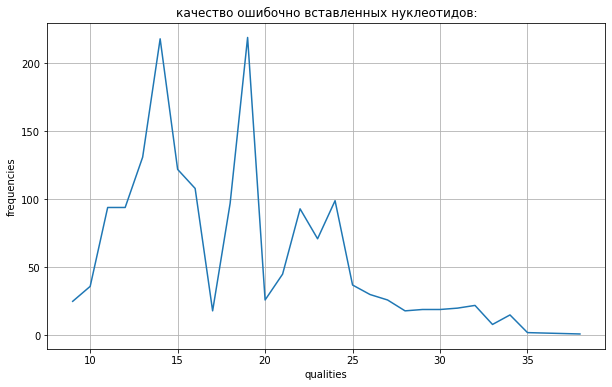

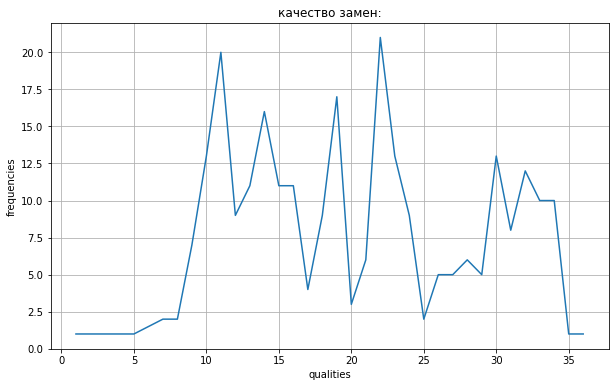

2021-03-19 17:46:17.297663


In [111]:
import datetime

print(datetime.datetime.now())
nucl_quality_stats("B22_730.sorted.bam", "gi|170079663|ref|NC_010473.1|")
print(datetime.datetime.now())

In [107]:
print(None in ['a', 'c'])

False


### test

#### Покрытие генома

среднее покрытие (по всему референсному геному): 0.0


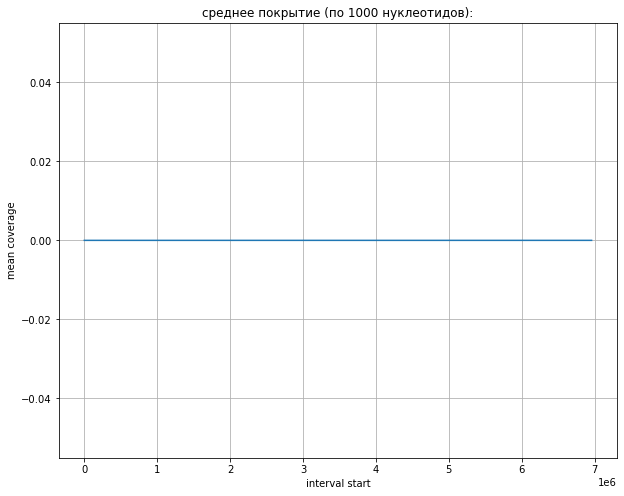

In [89]:
coverage_stats('test.sizes', 'test.BEDGRAPH', 'gnl|CBMA|contig000001', 6958602)

процент покрытого генома: 0

#### Средний процент ошибок в ридах

../samtools-1.11/samtools stats test.sorted.bam > test_stats.txt

grep 'error rate' test_stats.txt

результат:

SN	error rate:	0.000000e+00	# mismatches / bases mapped (cigar)

#### Таблица частот замен/вставок/удалений

bcftools stats test.bcf > test_calls.txt

grep '^ST' test_calls.txt

| Read\Reference | A | C | G | T | - |
|:-------------- |:-:|:-:|:-:|:-:|:-:|
| A              | - | 0 | 0 | 0 | 0 |
| C              | 0 | - | 0 | 0 | 0 |
| G              | 0 | 0 | - | 0 | 0 |
| T              | 0 | 0 | 0 | - | 0 |
| -              | 0 | 0 | 0 | 0 | - |

### B22-730

#### Покрытие генома

среднее покрытие (по всему референсному геному): 33.952685975676765


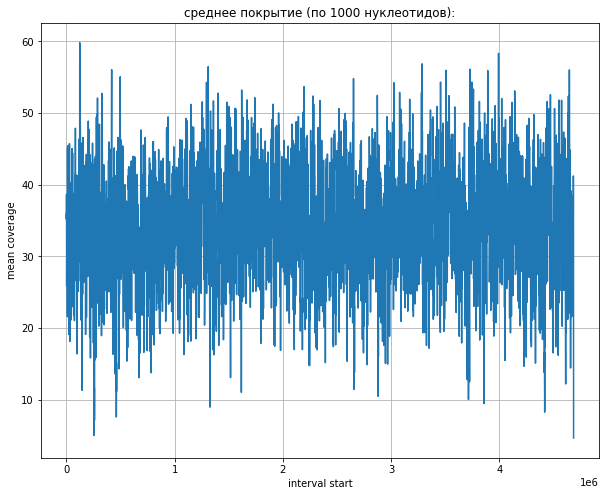

In [95]:
coverage_stats('B22_730.sizes', 'B22_730.BEDGRAPH', 'gi|170079663|ref|NC_010473.1|', 4686137)

процент покрытого генома близок к 100%:

длина покрытого генома

awk '$4 > 0 {sum += $3 - $2} END {print sum}' B22_730.BEDGRAPH

результат 4685573

длина всего генома

bioawk -c fastx '{ print $name, length($seq) }' < DH10B-K12.fasta

результат gi|170079663|ref|NC_010473.1|	4686137

In [93]:
4685573/4686137

0.9998796450039766

#### Средний процент ошибок в ридах

../samtools-1.11/samtools stats B22_730.sorted.bam > B22_730_stats.txt

grep 'error rate' B22_730_stats.txt

результат:

SN	error rate:	6.695761e-03	# mismatches / bases mapped (cigar)

#### Статистика длин инделов

bcftools stats B22_730.bcf > B22_730_calls.txt

grep '^IDD' B22_730_calls.txt | cut -f 3,4 | sort -k1 -n

результат:

length | number of sites

<pre>
-24	1
-7	1
-6	5
-5	14
-4	56
-3	419
-2	6469
-1	123129
1	172152
2	7634
3	796
4	216
5	114
6	74
7	38
8	35
9	23
10	19
11	14
12	11
13	13
14	8
15	5
16	10
17	4
18	2
20	1
</pre>

In [ ]:
nucl_quality_stats("B22_730.sorted.bam", )

#### Таблица частот замен/вставок/удалений

bcftools stats B22_730.bcf > B22_730_calls.txt

grep '^ST' B22_730_calls.txt

| Reference\Read | A | C | G | T | - |
|:-------------- |:-:|:-:|:-:|:-:|:-:|
| A              | - | 3753 | 17650 | 4404 |  |
| C              | 4023 | - | 2892 | 10470 |  |
| G              | 10581 | 2879 | - | 4067 |  |
| T              | 4321 | 17794 | 3801 | - |  |
| -              |  |  |  |  | - |


### C24-698

#### Покрытие генома

среднее покрытие (по всему референсному геному): 35.65372971383466


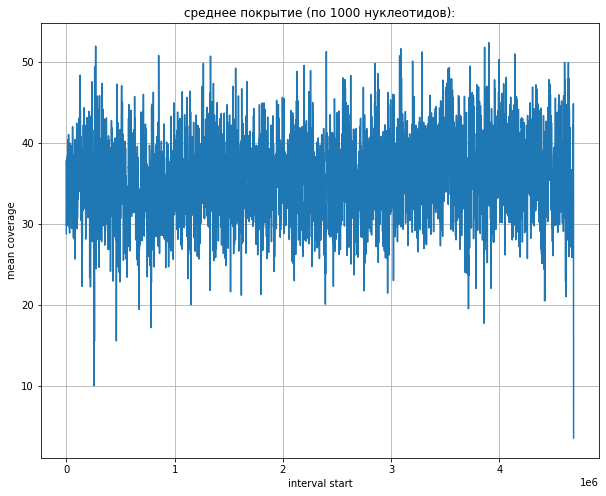

In [94]:
coverage_stats('C24_698.sizes', 'C24_698.BEDGRAPH', 'gi|170079663|ref|NC_010473.1|', 4686137)

процент покрытого генома близок к 100%:

длина покрытого генома

awk '$4 > 0 {sum += $3 - $2} END {print sum}' C24_698.BEDGRAPH

результат 4686136

длина всего генома

bioawk -c fastx '{ print $name, length($seq) }' < DH10B-K12.fasta

результат gi|170079663|ref|NC_010473.1|	4686137

In [96]:
4686136/4686137

0.999999786604617

#### Средний процент ошибок в ридах

../samtools-1.11/samtools stats C24_698.sorted.bam > C24_698_stats.txt

grep 'error rate' C24_698_stats.txt

результат:

SN	error rate:	3.680205e-03	# mismatches / bases mapped (cigar)

#### Статистика длин инделов

bcftools stats C24_698.bcf > C24_698_calls.txt

grep '^IDD' C24_698_calls.txt | cut -f 3,4 | sort -k1 -n

результат:

length | number of sites

<pre>
-8	1
-5	4
-4	20
-3	255
-2	3274
-1	71883
1	97350
2	4256
3	336
4	74
5	32
6	15
7	21
8	7
9	9
10	8
11	6
12	6
14	3
15	4
17	3
</pre>